Import needed stuff

In [4]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [5]:
country19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country18_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
country_df = country19_df.append(country18_df)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

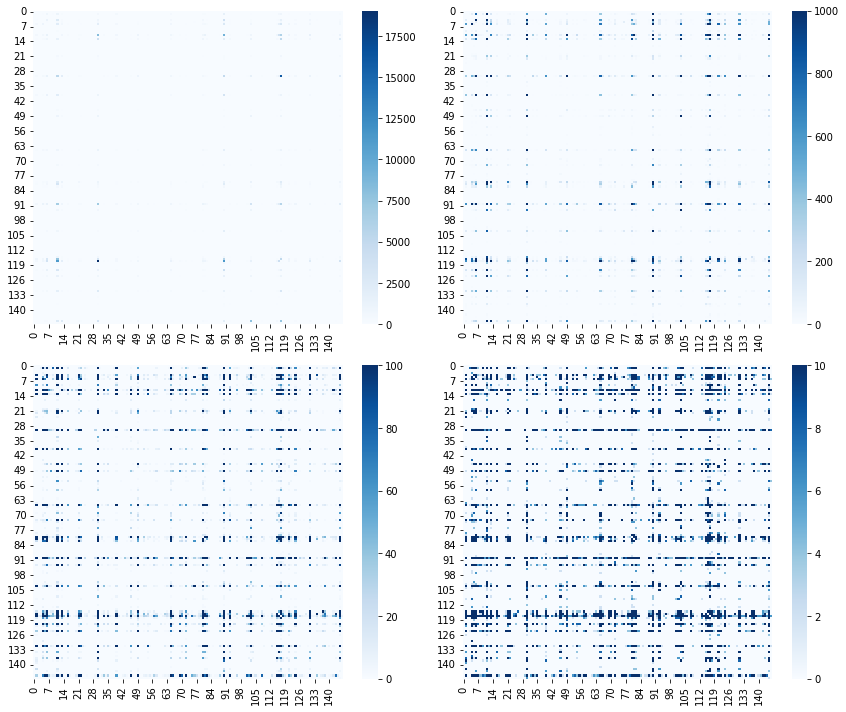

In [6]:
def analysis(country_df):
    country_df = country_df[country_df['Participant Profile']=='Learner']
    country_df = country_df[country_df['Activity (mob)'].str.contains('Student')]
    country_df = country_df[~country_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(country_df.loc[:, 'Sending Country Code' ]), set(country_df.loc[:, 'Receiving Country Code']))))
    country_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
    country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
    # Adjacency matrix
    country_serie = country_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

    country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
    country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
    nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

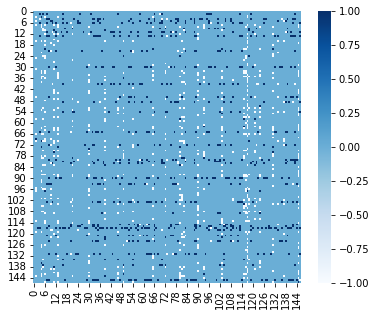

In [7]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [8]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 2


### Degree distribution

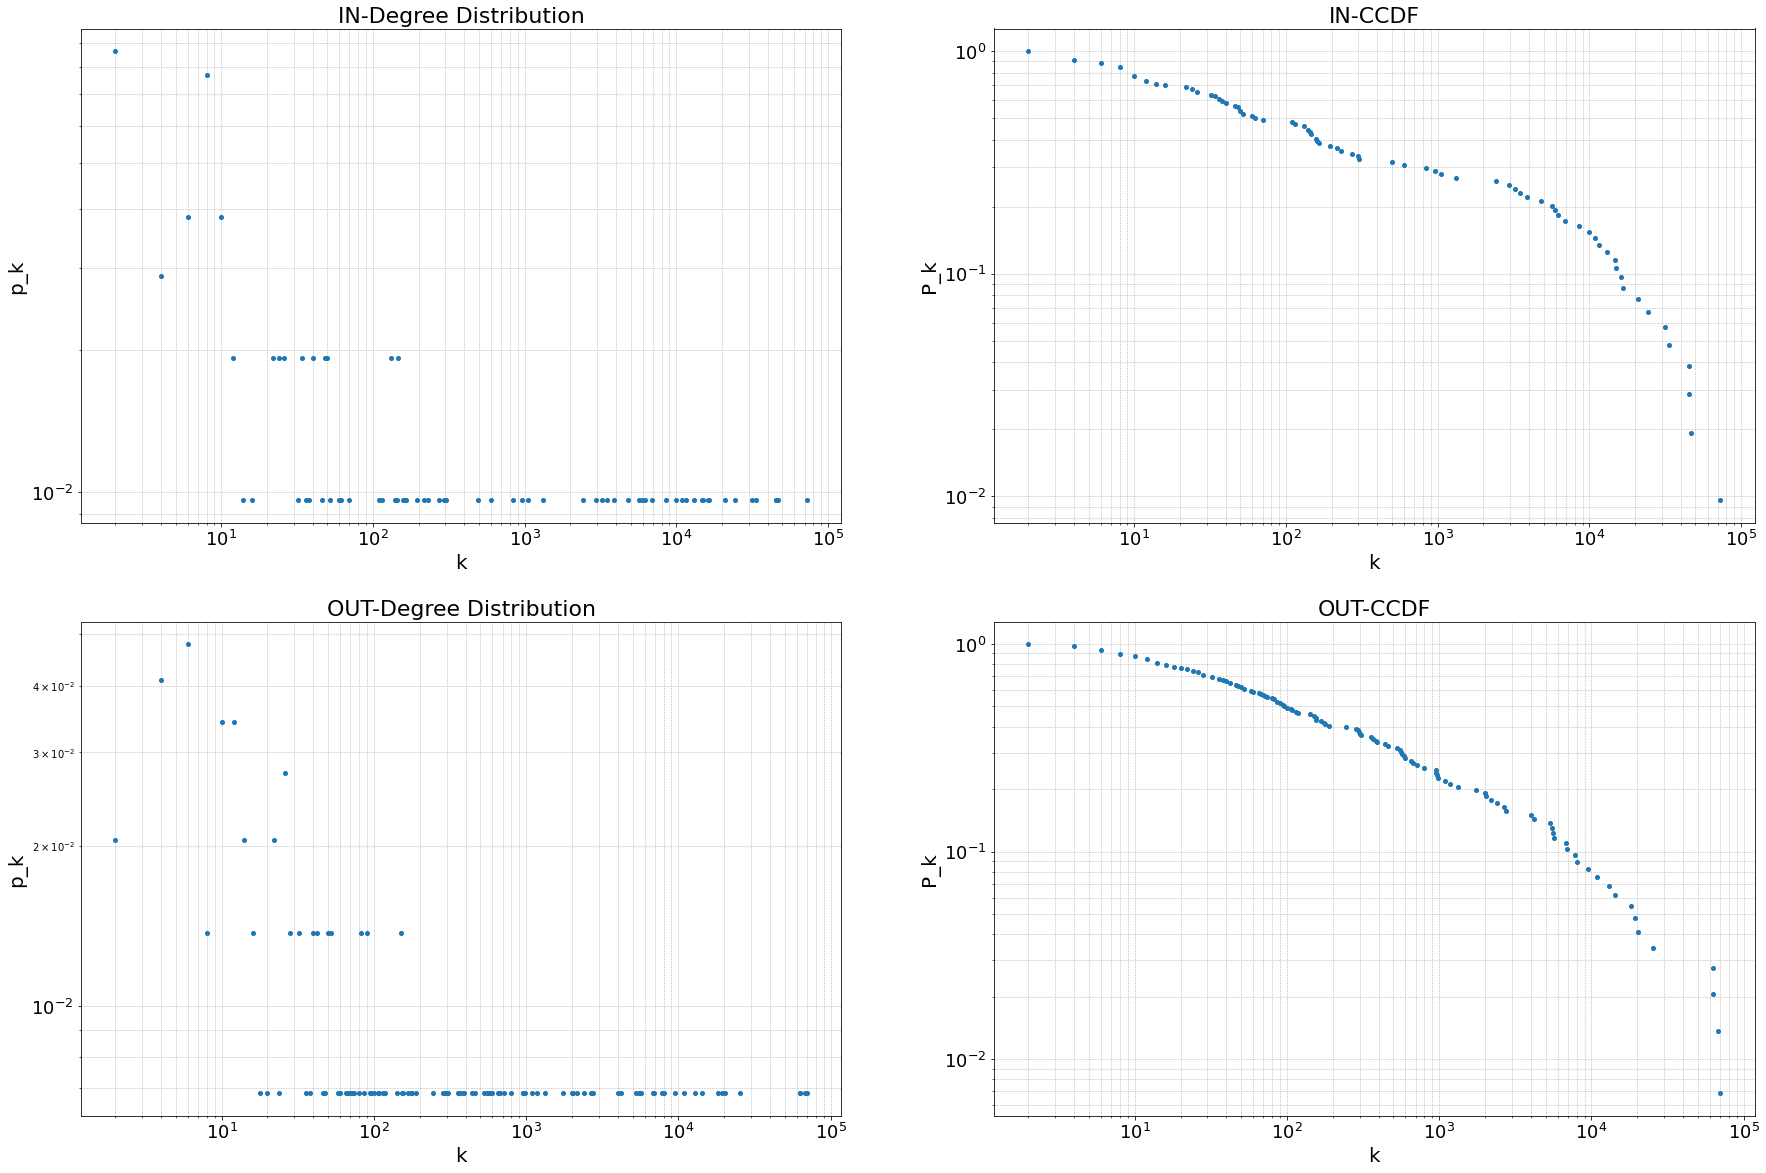

Top 10 for in degree


,Nodes,in degree
117,Spain,72526
30,Italy,46688
11,France,45580
90,Germany,45076
116,UK,33698
145,Poland,31500
13,Portugal,24302
6,Netherlands,21020
121,Sweden,16536
80,Czechia,16158


Top 10 for out degree


,Nodes,out degree
117,Spain,69826
90,Germany,67862
30,Italy,63182
11,France,62470
103,Turkey,25476
6,Netherlands,20288
145,Poland,19260
116,UK,18172
13,Portugal,14288
131,Belgium,12942


In [9]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

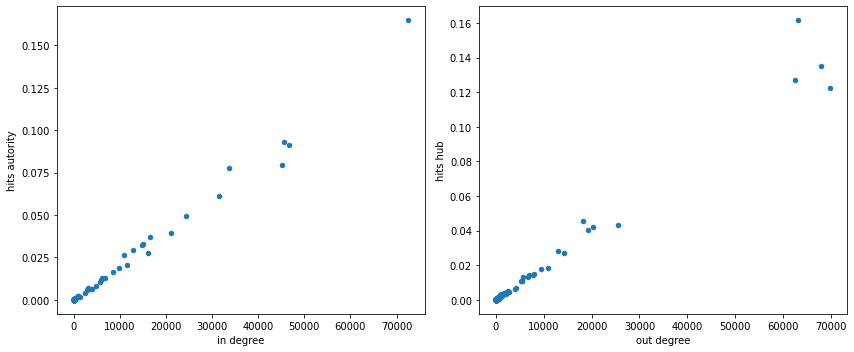

Top 10 for hits hub


,Nodes,hits hub
30,Italy,0.161576
90,Germany,0.135408
11,France,0.127085
117,Spain,0.122200
116,UK,0.045554
103,Turkey,0.043050
6,Netherlands,0.042306
145,Poland,0.040657
131,Belgium,0.028275
13,Portugal,0.027016


Top 10 for hits autority


,Nodes,hits autority
117,Spain,0.164803
11,France,0.093283
30,Italy,0.091191
90,Germany,0.079345
116,UK,0.077596
145,Poland,0.061080
13,Portugal,0.049354
6,Netherlands,0.039346
121,Sweden,0.036828
4,Finland,0.033024


In [10]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

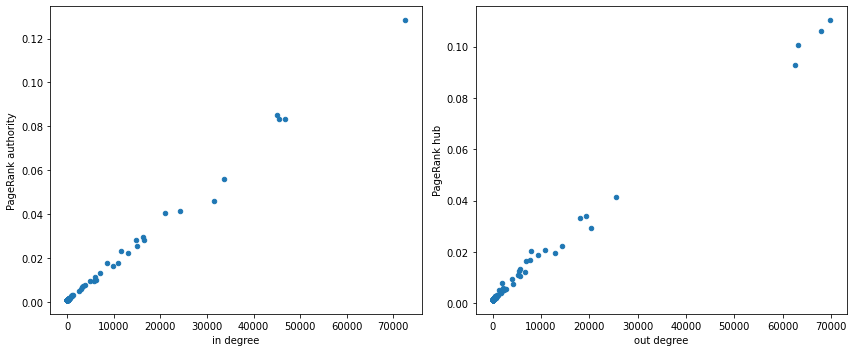

Top 10 for PageRank hub


,Nodes,PageRank hub
117,Spain,0.110257
90,Germany,0.105996
30,Italy,0.100815
11,France,0.093048
103,Turkey,0.041473
145,Poland,0.033889
116,UK,0.033424
6,Netherlands,0.029289
13,Portugal,0.022390
80,Czechia,0.020962


Top 10 for PageRank authority


,Nodes,PageRank authority
117,Spain,0.128283
90,Germany,0.084965
30,Italy,0.083311
11,France,0.083270
116,UK,0.056150
145,Poland,0.046034
13,Portugal,0.041512
6,Netherlands,0.040408
80,Czechia,0.029744
131,Belgium,0.028452


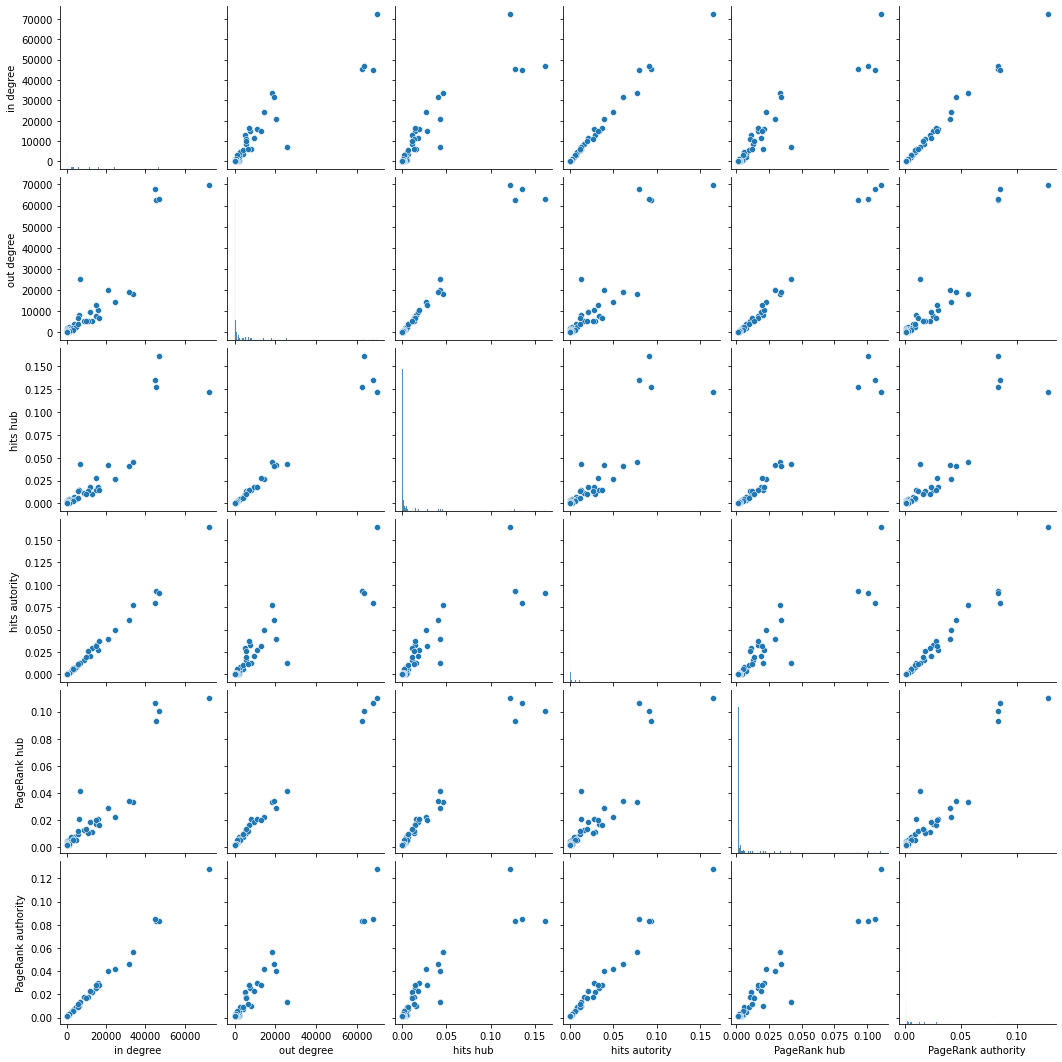

In [11]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank authority')

sns.pairplot(scores)
plt.show()

In [12]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank authority')
scores.sort_index(inplace=True)

In [13]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank authority,PageRank authority position
117,Spain,72526,1,0.164803,1,0.128283,1
90,Germany,45076,4,0.079345,4,0.084965,2
30,Italy,46688,2,0.091191,3,0.083311,3
11,France,45580,3,0.093283,2,0.083270,4
116,UK,33698,5,0.077596,5,0.056150,5
145,Poland,31500,6,0.061080,6,0.046034,6
13,Portugal,24302,7,0.049354,7,0.041512,7
6,Netherlands,21020,8,0.039346,8,0.040408,8
80,Czechia,16158,10,0.027760,13,0.029744,9
131,Belgium,14832,12,0.032101,11,0.028452,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
117,Spain,69826,1,0.122200,4,0.110257,1
90,Germany,67862,2,0.135408,2,0.105996,2
30,Italy,63182,3,0.161576,1,0.100815,3
11,France,62470,4,0.127085,3,0.093048,4
103,Turkey,25476,5,0.043050,6,0.041473,5
145,Poland,19260,7,0.040657,8,0.033889,6
116,UK,18172,8,0.045554,5,0.033424,7
6,Netherlands,20288,6,0.042306,7,0.029289,8
13,Portugal,14288,9,0.027016,10,0.022390,9
80,Czechia,10824,11,0.018478,11,0.020962,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

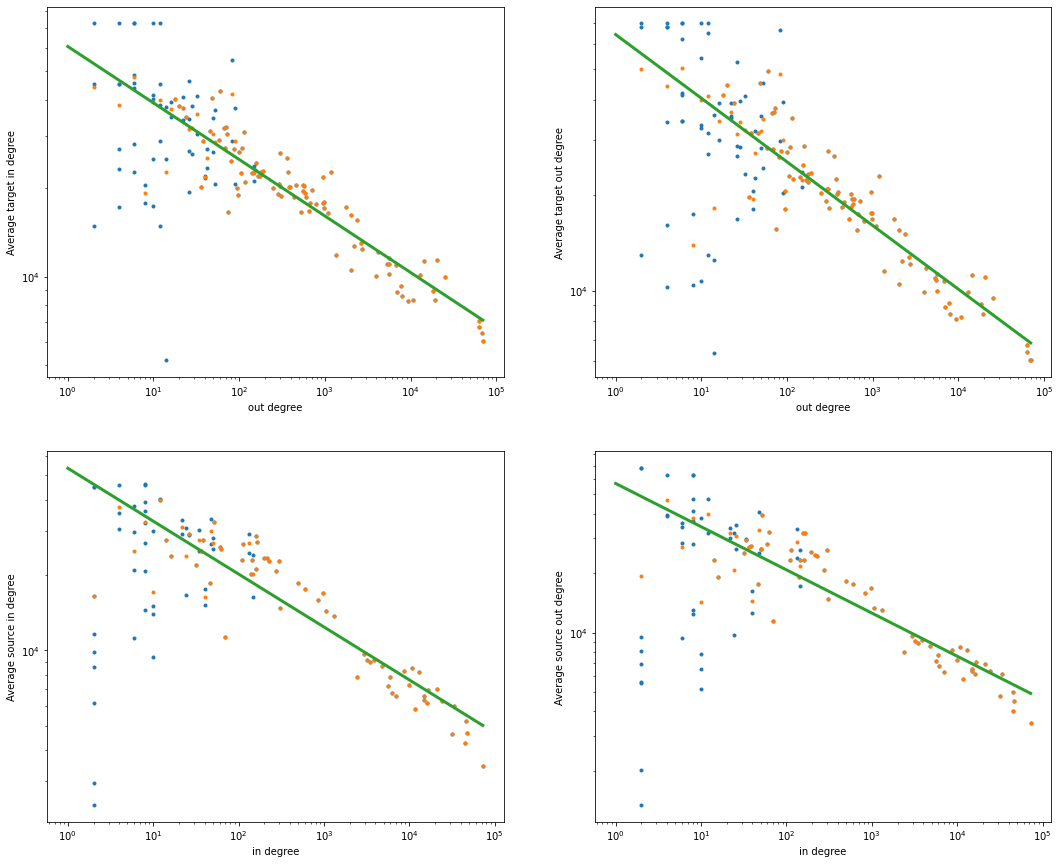

(-0.19190430299796593,
 -0.20100582390354507,
 -0.2114176952655288,
 -0.2185614973229747)

In [14]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

2612 2612


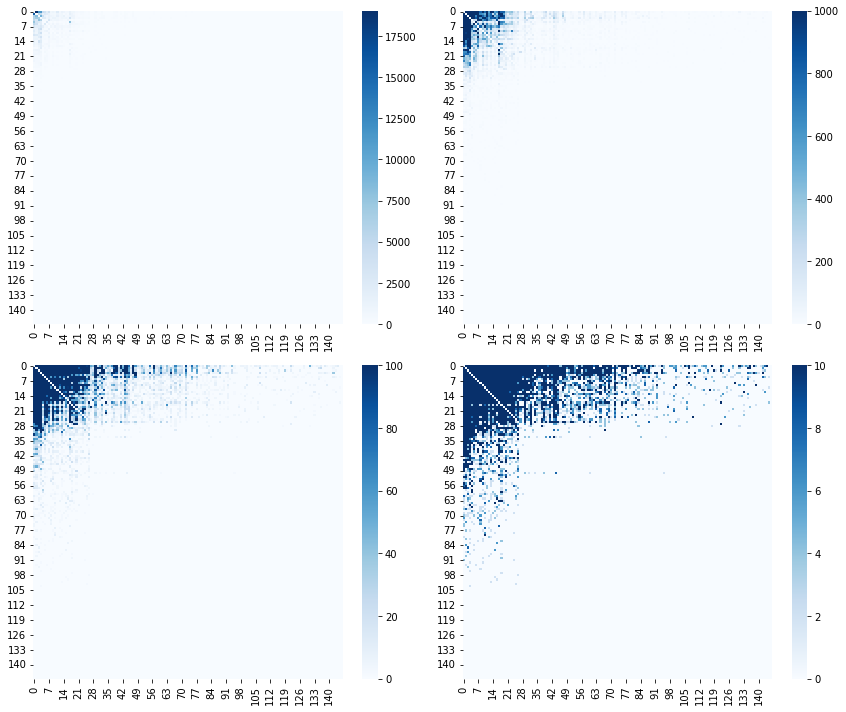

In [15]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c = c[['source ID', 'target ID', 'weight']]
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
print(len(val.flatten()), len(row))
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

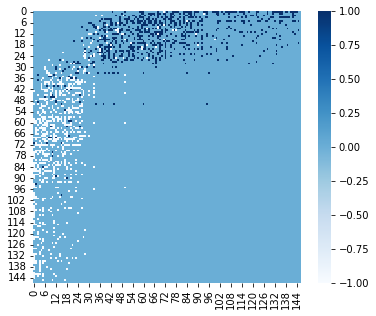

In [16]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [17]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
2,Togo,0
7,"Iran, Islamic Republic of",0
8,"Moldova, Republic of",0
11,France,0
12,Bhutan,0
...,...,...
136,Nepal,0
140,Ecuador,0
141,Mongolia,0
145,Poland,0


,Nodes,Community
1,Denmark,1
3,Philippines,1
4,Finland,1
5,Croatia,1
6,Netherlands,1
...,...,...
133,Trinidad and Tobago,1
134,Malta,1
137,Cyprus,1
138,Jordan,1


,Nodes,Community
10,"Korea, Republic of",2
32,Kenya,2
36,Peru,2
38,Bangladesh,2
57,Belarus,2
61,El Salvador,2
67,Sudan,2
80,Czechia,2
86,Uruguay,2
93,Lithuania,2


,Nodes,Community
0,nan,3


## Geographic Heat map 

In [18]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank authority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)

In [ ]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# Countries ordered by PageRank hub score
display(european_df[['country', 'PageRank hub']].sort_values('PageRank hub', ascending=False))
# Countries ordered by PageRank authority score
display(european_df[['country', 'PageRank authority']].sort_values('PageRank authority', ascending=False))

,country,PageRank hub
34,Spain,0.109555
26,Germany,0.108978
54,Italy,0.097891
76,France,0.089319
45,Turkey,0.043546
...,...,...
3,Moldova,0.002014
84,Belarus,0.001926
115,Montenegro,0.001711
14,Liechtenstein,0.001487


,country,PageRank authority
34,Spain,0.127210
26,Germany,0.086031
76,France,0.084201
54,Italy,0.080548
129,United Kingdom,0.062429
...,...,...
115,Montenegro,0.001122
25,Kosovo,0.001115
84,Belarus,0.001110
3,Moldova,0.001080


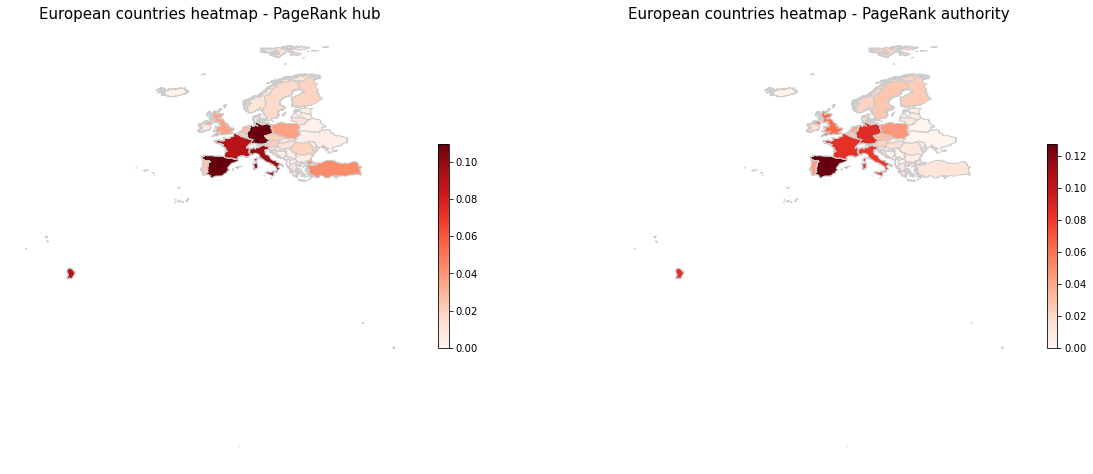

In [ ]:
# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
plt_list = ['PageRank hub', 'PageRank authority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)

# ax4 = np.reshape(ax4, (2,2))
# plt.savefig('eu_pagerank.png')

## Erasmus exchanges vs total students enrolled per country

In [ ]:
# dataset containing for each european university the students enrolled in ISCED 5-7 (tertiary education and master degree)
isced57_df = pd.read_csv("eter-export-2016.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()
        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')

print('Top 10 countries for students enrollment')
display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))

Top 10 countries for students enrollment


,country,Total students enrolled ISCED 5-7
17,Turkey,7107650.0
12,Germany,2625241.0
38,United Kingdom,2263020.0
19,Italy,1797986.0
13,Spain,1491419.0
30,Poland,1418588.0
33,Netherlands,720583.0
37,Greece,704969.0
6,Sweden,438578.0
23,Portugal,323467.0


In [ ]:
european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

# threshold set because some countries had too big values wrt the average
european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)
# maybe set better this thresholds

eu_w_copy = european_df_w.copy()
eu_w_copy.dropna(inplace = True)
# Countries ordered by weighted PageRank hub score
eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_hub']])
# Countries ordered by weighted PageRank authority score
eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_aut']])


,country,weight_pr_hub
0,Luxembourg,2.000000e-07
1,Liechtenstein,2.000000e-07
2,Malta,1.615408e-07
3,Romania,1.417199e-07
4,Slovenia,1.026944e-07
5,Lithuania,1.007646e-07
6,Estonia,8.790258e-08
7,Belgium,8.692329e-08
8,Slovakia,7.897599e-08
9,Spain,7.345657e-08


,country,weight_pr_aut
0,Luxembourg,2.000000e-07
1,Malta,2.000000e-07
2,Liechtenstein,2.000000e-07
3,Slovenia,1.755364e-07
4,Portugal,1.335447e-07
5,Estonia,1.275060e-07
6,Belgium,1.089761e-07
7,Czechia,1.052977e-07
8,Finland,9.151670e-08
9,Lithuania,8.724522e-08


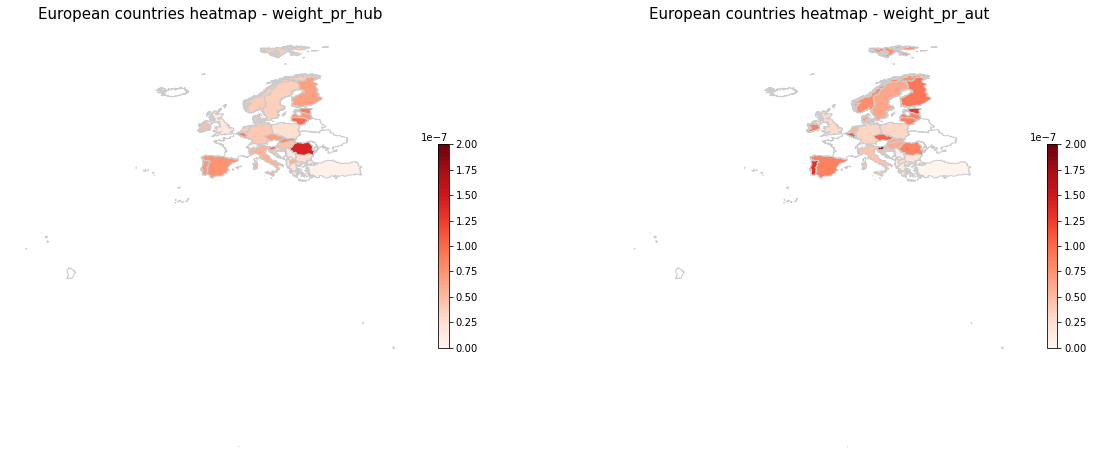

In [ ]:
fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
plt_list = ['weight_pr_hub', 'weight_pr_aut']
for i in range(len(plt_list)):
    # european_df_w.drop(european_df_w[plt_list[i]].idxmax(), inplace=True)
    european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                              vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
    ax7[i].axis('off')
    fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
    ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
# plt.savefig('eu_pagerank_weight.png')

## GeoPlot for Communities

Text(0.5, 1.0, 'European countries - Commmunity')

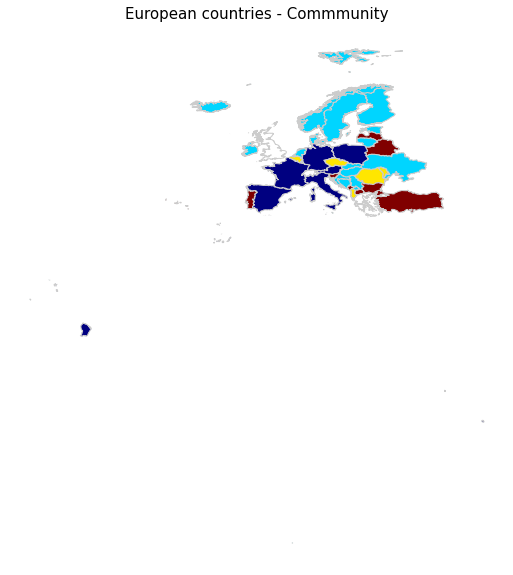

In [ ]:
node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

eu_communities = european_df.copy()
eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

fig5, ax5 = plt.subplots(figsize=(10,10))
eu_communities.plot(column='Community', ax=ax5, edgecolor='0.8', linewidth=1, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

# plt.savefig('eu_community.png')